In [1]:
import os
os.chdir("..")

In [2]:
import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from torchvision import transforms
import torchvision.models as models

In [3]:
directory = "./data/Sintel_frames/all"
video_frames_path = sorted(glob.glob(directory + "/*.png"), key= lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

clip_range = [240, 315]
clip_frames_path = video_frames_path[slice(*[c - 1 for c in clip_range])]

In [4]:
def data_process(frames):
    # Define preprocessing steps
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor(),         # Convert image to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]  # Normalize using ImageNet mean and std
        ),
    ])
    tensors = []
    for frame_path in frames:
        image = Image.open(frame_path).convert("RGB")
        input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
        tensors.append(input_tensor)
    return torch.cat(tensors)

def batchify(tensors, batch_size):
    n_batches = len(tensors) // batch_size
    tensors = tensors[:n_batches * batch_size]
    batches = tensors.view(n_batches, batch_size, 3, 224, 224)
    for batch in batches:
        yield batch

In [5]:
def pca(tensor):

    array = tensor.numpy()

    # Apply PCA to reduce dimensions from 768 to 2
    pca = PCA(n_components=2)
    reduced_array = pca.fit_transform(array)

    return reduced_array

In [6]:
def plot_pca(reduced_array):
    # Get the indices for coloring
    indices = np.arange(len(reduced_array))

    # Plot the lines connecting the points in index order
    plt.figure(figsize=(10, 6))
    plt.plot(
        reduced_array[:, 0],  # x-coordinates
        reduced_array[:, 1],  # y-coordinates
        color='gray',         # Line color
        linestyle='-',        # Solid line
        alpha=0.7,            # Transparency
        label='Connections'   # Legend label
    )

    # Scatter plot the points on top of the lines
    scatter = plt.scatter(
        reduced_array[:, 0],  # x-coordinates
        reduced_array[:, 1],  # y-coordinates
        c=indices,            # Color by index
        cmap='viridis',        # Color map
        s=50,                  # Marker size
        label='Points'         # Legend label
    )

    # Add a color bar to show the index
    plt.colorbar(scatter, label="Index")

    # Optionally, annotate each point with its index
    for i, (x, y) in enumerate(reduced_array):
        plt.text(x, y, str(i), fontsize=8, ha='right', color='black')

    # Add labels and title
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title("Scatter Plot with Lines Connecting Points by Index")

    # Show the plot
    plt.show()                     

In [7]:
# Load the DINOv2 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
# Set the model to evaluation mode
dino_model.eval()

@torch.no_grad()
def dino_forward(x):
    embeddings = dino_model(x, is_training=True)
    return embeddings["x_norm_clstoken"]

Using cache found in /Users/aligarjani/.cache/torch/hub/facebookresearch_dinov2_main
/Users/aligarjani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/aligarjani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/aligarjani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [8]:
import clip

model, preprocess = clip.load("ViT-B/16")

@torch.no_grad()
def clip_forward(x):
    embeddings = model.encode_image(x)
    return embeddings

In [9]:
def load_moco_v3():
    # Load MoCo v3 model pre-trained on ImageNet
    model = models.resnet50()
    checkpoint = torch.hub.load_state_dict_from_url(
        'https://dl.fbaipublicfiles.com/moco-v3/r-50-1000ep/r-50-1000ep.pth.tar',
        map_location="cpu"
    )
    # Rename moco pre-trained keys
    state_dict = checkpoint['state_dict']
    for k in list(state_dict.keys()):
        # Remove prefix
        if k.startswith('module.base_encoder'):
            state_dict[k[len("module.base_encoder."):]] = state_dict[k]
        del state_dict[k]
    msg = model.load_state_dict(state_dict, strict=False)
    
    # Remove the final classification layer
    model.fc = torch.nn.Identity()
    model.eval()
    return model

moco_model = load_moco_v3()

@torch.no_grad()
def moco_forward(x):
    embeddings = moco_model(x)
    return embeddings

In [11]:
import timm

import torch
from torch import nn
from torch.nn import functional as F

class FrameEncoder(nn.Module):
    def __init__(self, temperature=0.05, pretrained=False):
        super().__init__()
        # Load ViT base model
        self.backbone = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        # Get embedding dimension from the model
        self.embedding_dim = self.backbone.embed_dim
        self.temperature = temperature
        
    def get_similarity_matrix(self, embeddings, temperature):
        # Normalize the embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute the similarity matrix and scale it by the temperature
        similarity_matrix = torch.mm(embeddings[:-2], embeddings.t()[:,:-1])
        similarity_matrix /= temperature
        
        # Create a mask for the lower triangular part and set the lower triangular part to -inf
        mask = torch.tril(torch.ones_like(similarity_matrix), diagonal=-1)
        similarity_matrix = similarity_matrix.masked_fill(mask.bool(), float('-inf'))
        
        return similarity_matrix
    
    def get_softmax_similarity_matrix(self, x, frame_id):
        embeddings = self.backbone(x)
        # Sort the embeddings by frame_id
        sorted_indices = torch.argsort(frame_id)
        embeddings = embeddings[sorted_indices]
        similarity_matrix = self.get_similarity_matrix(embeddings, self.temperature)
        return F.softmax(similarity_matrix, dim=1)
    
    def get_feature_attention(self, x):
        embeddings = self.backbone.forward_features(x)
        
    def forward_loss(self, embeddings, frame_id):
        # Sort the embeddings by frame_id
        sorted_indices = torch.argsort(frame_id)
        embeddings = embeddings[sorted_indices]
        similarity_matrix = self.get_similarity_matrix(embeddings, self.temperature)
        # Compute cross-entropy loss
        labels = torch.arange(similarity_matrix.size(0)).to(similarity_matrix.device)
        return F.cross_entropy(similarity_matrix, labels)
        
    def forward(self, x, frame_id=None, return_loss=False):
        if return_loss:
            assert frame_id is not None, "Frame ID is required for loss computation"
            embeddings = self.backbone(x)
            loss = self.forward_loss(embeddings, frame_id)
            return embeddings, loss
        else:
            return self.backbone(x)
        
encoder = FrameEncoder()
encoder.load_state_dict(torch.load("checkpoints/run-1/encoder_99.pth"))

@torch.no_grad()
def frame_encoder_forward(x):
    return encoder(x)


/var/folders/bc/h5v233gn3n317fvs90zjj9_00000gn/T/ipykernel_19931/976981368.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("checkpoin

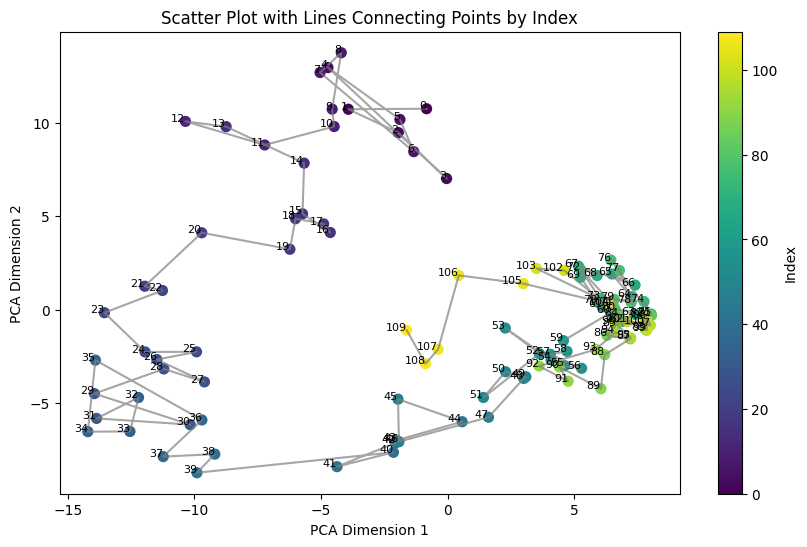

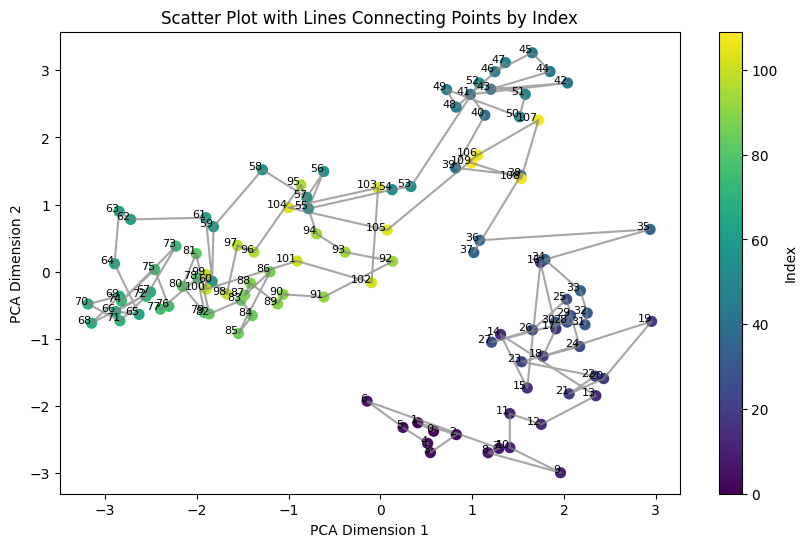

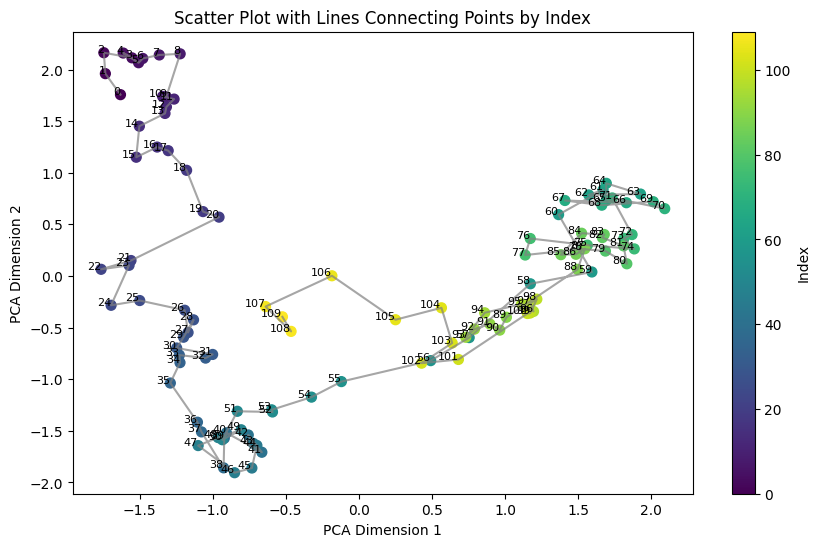

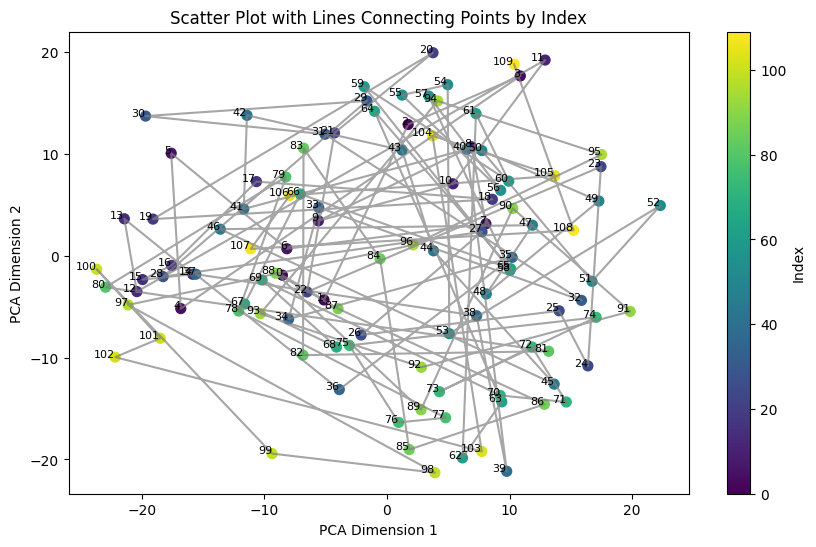

In [12]:
def run(clip_range, forward_fn):
    clip_frames_path = video_frames_path[slice(*[c - 1 for c in clip_range])]
    tensors = data_process(clip_frames_path)
    all_embeddings = []
    for input_tensor in batchify(tensors, 5):
        with torch.no_grad():
            embeddings = forward_fn(input_tensor)
            all_embeddings.append(embeddings)
    all_embeddings = torch.cat(all_embeddings)
    reduced_array = pca(all_embeddings)
    plot_pca(reduced_array)

run([315, 425], forward_fn=dino_forward)
run([315, 425], forward_fn=clip_forward)
run([315, 425], forward_fn=moco_forward)
run([315, 425], forward_fn=frame_encoder_forward)